# Figures

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import napari
import numpy as np
import pandas as pd
import seaborn as sns
import tifffile
from scipy.stats import norm, truncnorm

paper_width = 8.3
paper_margin = 0
figure_dpi = "figure"
figure_dir = "figures"

rng = np.random.default_rng(seed=123)

def save_and_show(figure_file_name):
    if figure_dir is not None:
        Path(figure_dir).mkdir(exist_ok=True)
        plt.savefig(Path(figure_dir) / figure_file_name, dpi=figure_dpi, bbox_inches="tight")
    plt.show()

sns.set_theme(
    context="paper",
    style="ticks",
    palette="colorblind",
    color_codes=True,
    rc={
        "figure.figsize": (paper_width - 2 * paper_margin, 4 * (paper_width - 2 * paper_margin) / 6),
        "figure.titlesize": 12,  # "large",
        "axes.titlesize": 10,  # 9.6,
        "axes.labelsize": 10,  # 9.6,
        "legend.fontsize": 10,  # 8.8,
        "legend.title_fontsize": 10,  # 9.6,
        "xtick.labelsize": 8,  # 8.8,
        "xtick.major.size": 7,  # 4.8,
        "xtick.minor.size": 5,  # 3.2,
        "ytick.labelsize": 8,  # 8.8,
        "ytick.major.size": 7,  # 4.8,
        "ytick.minor.size": 5,  # 3.2,
        "font.size": 10,  # 9.6,
        "font.family": 'lmodern',
        "text.usetex": True,
        "text.latex.preamble": " ".join([
            r"\usepackage{amsmath}",
            r"\usepackage{lmodern}",
        ]),
    },
)
    
sns.color_palette()

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

## Figure 1

Created with BioRender

## Figure 2

In [2]:
cell_data = pd.read_csv("../kuett_catena_2022/sectioning/cell_data.csv")
cell_slice_data = pd.read_csv("../kuett_catena_2022/sectioning/cell_slice_data.csv")

In [3]:
# empirically observed cell section spans

def get_empirical_cell_section_span(sectioning_axis_name):
    df = cell_slice_data[cell_slice_data["sectioning_axis_name"] == sectioning_axis_name]
    df = df.groupby(["section_thickness_um", "section_offset_um", "cell_id"]).size().reset_index(name="cell_section_span")
    df = df.groupby(["section_thickness_um", "cell_id"])["cell_section_span"].mean().reset_index(name="cell_section_span")    
    df = pd.merge(df, cell_data.loc[cell_data["sectioning_axis_name"] == "z", ["cell_id", "proj_cell_radius_um"]])
    n_short = np.floor(df["section_thickness_um"] - ((2 * df["proj_cell_radius_um"]) % df["section_thickness_um"])) + 1
    n_long = np.ceil((2 * df["proj_cell_radius_um"]) % df["section_thickness_um"]) - 1
    df["cell_section_span"] = (n_short * df["cell_section_span"] + n_long * (df["cell_section_span"] - 1)) / (n_short + n_long)
    return df

In [4]:
# model fitted to empirically observed radii

t_obs = cell_slice_data["section_thickness_um"].unique()
d_obs = 2 * cell_data.loc[cell_data["sectioning_axis_name"] == "z", "proj_cell_radius_um"].to_numpy()

mu_d = d_obs.mean()
sigma_d = d_obs.std()

n = len(d_obs)
t = t_obs
d = truncnorm.rvs(-mu_d / sigma_d, mu_d / sigma_d, loc=mu_d, scale=sigma_d, size=n, random_state=rng)
s = np.ceil(d[:, np.newaxis] / t[np.newaxis, :])

mu_d, sigma_d ** 2

(7.9312735863614465, 3.1263231347964675)

In [5]:
def plot_cell_diameter(ax=None, num=1000, **kdeplot_kwargs):
    if ax is None:
        ax = plt.gca()
    sns.kdeplot(
        x=2 * cell_data.loc[cell_data["sectioning_axis_name"] == "z", "proj_cell_radius_um"],
        label=r"$d_z = 2 \sqrt{\frac{A_z}{\pi}}$",
        linestyle="-",
        color="C7",
        legend=False,
        ax=ax,
        **kdeplot_kwargs,
    )
    x = np.linspace(
        2 * cell_data.loc[cell_data["sectioning_axis_name"] == "z", "proj_cell_radius_um"].min(),
        2 * cell_data.loc[cell_data["sectioning_axis_name"] == "z", "proj_cell_radius_um"].max(),
        num,
    )
    y = norm.pdf(x, loc=mu_d, scale=sigma_d)
    ax.plot(x, y, label=r"$D \sim \mathcal{N}(\mu_d, \sigma_d^2)$", linestyle=":", color="C7")
    # ax.text(
    #     0.95,
    #     0.5,
    #     f"""$\\hat{{\\mu}}_r = {mu_d:.3f}$
    #         $\\hat{{\\sigma}}_r = {sigma_d:.3f}$""",
    #     transform=ax.transAxes,
    #     ha="right",
    #     va="center",
    # )
    ax.set_title(r"Cell diameter (circular approximation)")
    ax.set_xlabel(r"Diameter [$\mu m$]")
    ax.set_ylabel(r"Density")
    ax.legend(loc="upper right")

In [6]:
mask = tifffile.imread("../kuett_catena_2022/sectioning/mask.tiff")
mask = np.pad(mask, ((20, 20), (40, 40), (40, 40)))
mask[mask.shape[0] // 2, :, :] = np.amax(mask) + 1
mask[:, mask.shape[1] // 2, :] = mask[:, :, mask.shape[2] // 2] = np.amax(mask) + 6

viewer = napari.view_labels(mask, scale=(2, 1, 1), ndisplay=3)
viewer.camera.angles=(-20, 40, -30)
mask_screenshot = viewer.screenshot()
viewer.close()

def plot_mask_screenshot(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.imshow(np.where(mask_screenshot != 0, mask_screenshot, 255))
    ax.axis("off")

In [7]:
def plot_cell_section_span(ax=None, **lineplot_kwargs):
    if ax is None:
        ax = plt.gca()
    data = pd.concat(
        {
            ("Sx", "sectioning"): get_empirical_cell_section_span("x"),            
            ("Sy", "sectioning"): get_empirical_cell_section_span("y"),            
            ("Sz", "sectioning"): get_empirical_cell_section_span("z"),
            ("S", "model"): pd.DataFrame(data=s, columns=t).melt(var_name="section_thickness_um", value_name="cell_section_span"),
        },
        names=["hue", "style", ""],
    ).reset_index()
    data["section_thickness_um"] = data["section_thickness_um"].astype("category")
    g = sns.lineplot(
        data=data,
        x="section_thickness_um",
        y="cell_section_span",
        hue="hue",
        style="style",
        hue_order=["Sx", "Sy", "Sz", "S"],
        dashes={"sectioning": "", "model": (1, 1)},
        palette=["C0", "C1", "C2", "C7"],
        marker="o",
        ci=None,
        legend=False,
        ax=ax,
        **lineplot_kwargs,
    )
    ax.set_title(r"Cell section span")
    ax.set_xlabel(r"Section thickness [$\mu m$]")
    ax.set_ylabel(r"Number of sections (mean)")
    ax.legend(
        labels=[
            r"adjusted $s_x$",
            r"adjusted $s_y$",
            r"adjusted $s_z$",
            r"$S = \lceil Dt^{-1} \rceil$",
        ],
        loc="upper right",
    )

In [8]:
def plot_cell_miss_probab(ax=None, **kdeplot_kwargs):
    if ax is None:
        ax = plt.gca()
    data = pd.DataFrame(data=1 / s, columns=t).melt(
        var_name="section_thickness_um", value_name="cell_miss_probab"
    )
    data["section_thickness_um"] = data["section_thickness_um"].astype("category")
    sns.kdeplot(
        data=data,
        x="cell_miss_probab",
        hue="section_thickness_um",
        ax=ax,
        bw_method=1,
        **kdeplot_kwargs,
    )
    sns.rugplot(
        data=data.drop_duplicates(),
        x="cell_miss_probab",
        hue="section_thickness_um",
        height=0.05,
        ax=ax,
    )
    sns.move_legend(ax, "upper right", title="Section thickness [$\\mu m$]", ncol=2)
    ax.set_title(r"Cell miss probability (bw=$1.0$)")
    ax.set_xlabel(r"$P($cell absent in next section$) = S^{-1}$")
    ax.set_ylabel(r"Density")
    ax.set_xlim(0, 1)

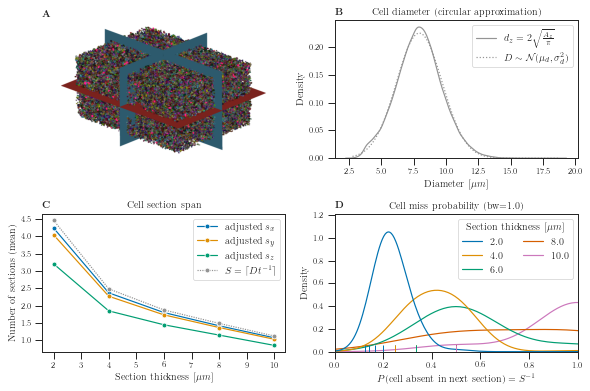

In [9]:
fig, axes = plt.subplot_mosaic(
    """AB
       CD""",
)
plot_mask_screenshot(ax=axes["A"])
plot_cell_diameter(ax=axes["B"])
plot_cell_section_span(ax=axes["C"])
plot_cell_miss_probab(ax=axes["D"])
plt.tight_layout()
for label, ax in axes.items():
    ax.set_title(f"\\textbf{{{label}}}", loc="left")
save_and_show("Figure2.pdf")

## Figure 3